## 이미지 노이즈 제거


In [21]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

### 데이터 로드

In [22]:
(x_train,_),(x_test,_) = fashion_mnist.load_data()

### 데이터 전처리

In [23]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### 임의의 노이즈 추가

In [24]:
noise_factor = 0.2

x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min = 0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min = 0., clip_value_max=1.)

### 노이즈가 추가된 이미지 확인

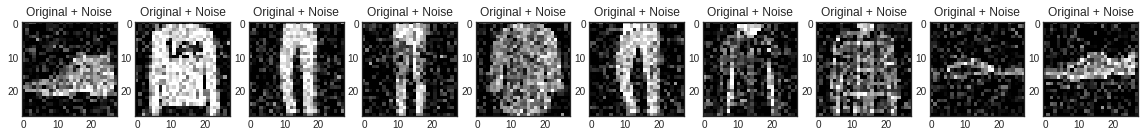

In [25]:
n = 10
plt.figure(figsize=(20,2))
for i in range(n):
  ax = plt.subplot(1,n,i+1)
  plt.title('Original + Noise')
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()
plt.show()

### 모델 정의

In [29]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()

    self.encoder = Sequential([Input(shape=(28,28,1)),
                               Conv2D(16,(3,3), activation='relu', padding='same',strides=2),
                               Conv2D(8,(3,3), activation='relu', padding='same',strides=2)])
    self.decoder = Sequential([Conv2DTranspose(8,kernel_size=3, strides=2, activation='relu',padding='same'),
                               Conv2DTranspose(16,kernel_size=3, strides=2, activation='relu',padding='same'),
                               Conv2D(1,kernel_size=(3,3), activation='sigmoid', padding='same')])
    
  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

### 모델 생성 및 컴파일

In [30]:
autoencoder =Denoise()
autoencoder.compile(optimizer='adam',loss=MeanSquaredError())

### 모델 학습

In [31]:
autoencoder.fit(x_train_noisy,x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy,x_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0166 - val_loss: 0.0096
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0088 - val_loss: 0.0083
Epoch 3/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.007

### 인코더 요약

In [33]:
autoencoder.encoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


### 디코더 요약

In [34]:
autoencoder.decoder.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_10 (Conv2DT (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


### 노이즈가 있는 이미지와 없는 이미지 시각화

In [35]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

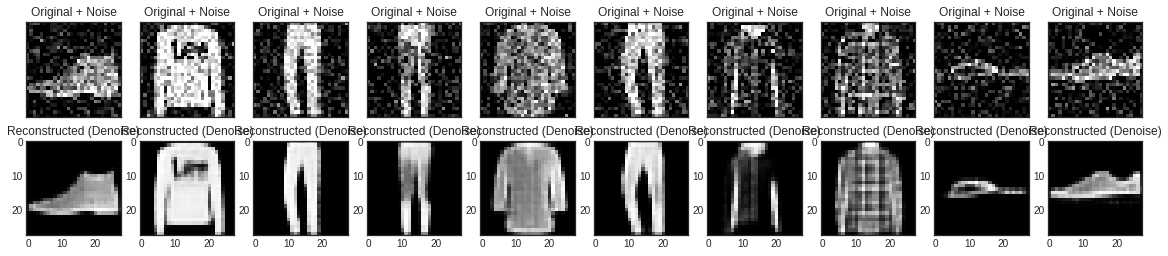

In [37]:
n = 10
plt.figure(figsize=(20,4))

for i in range(n):
  ax = plt.subplot(2,n,i+1)
  plt.title('Original + Noise')
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  bx = plt.subplot(2,n,i+1+n)
  plt.title('Reconstructed (Denoise)')
  plt.imshow(tf.squeeze(decoded_imgs[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()